In [1]:
#| default_exp wrapping

In [1]:
#| export

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import interpolation as tcinterp
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import interface_open3d as into3d
from blender_tissue_cartography import interface_pymeshlab as intmsl

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#| export

import numpy as np
from skimage import transform
from scipy import stats, spatial, linalg
import os
import matplotlib.pyplot as plt
import mcubes
import pymeshlab
import open3d as o3d
from copy import deepcopy

In [3]:
from tqdm.notebook import tqdm
from importlib import reload
np.set_printoptions(suppress=True)

## Automated wrapping

This notebook builds the tools for automated mesh wrapping (setting vertex positions of one mesh to the closest point on another mesh). This is a part of the pipeline for dynamic surfaces discussed in notebook 4.

## Loading and segmenting the dataset

We will use the same dataset - a _Drosophila_ example - as in notebook 3.

In [4]:
metadata_dict = {'filename': 'wrapping_example/Drosophila_CAAX-mCherry',
                 'resolution_in_microns': (1.05, 1.05, 1.05), # lightsheet data has isotropic resolution
                 'subsampling_factors': (1/2, 1/2, 1/2),
                }

In [5]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (1, 190, 509, 188)


In [6]:
subsampled_image = transform.rescale(image, metadata_dict['subsampling_factors'],
                                     channel_axis=0, preserve_range=True)
print("subsampled image shape:", subsampled_image.shape)

subsampled image shape: (1, 95, 254, 94)


## Create 3d segmentation

Now create a 3d segmentation, in this case using ilatik. We use [ilastik binary pixel classification](https://www.ilastik.org/documentation/pixelclassification/pixelclassification). We could post-process the ilastik output here, for example using morphsnakes. We then load the segmentation back into the jupyter notebook.

The bright dots outside the embryo are fluorescent beads necessary for sample registration in lightsheet microscopy. You can ignore them.

Attention: when importing the `.h5` into ilastik, make sure the dimension order is correct! In this case, `czyx` for both export and import.

In [7]:
# we now save the subsampled image a .h5 file for input into ilastik for segmentation

tcio.write_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image)

In [8]:
# after creating an ilastik project, training the model, and exporting the probabilities, we load the segmentation

segmentation = tcio.read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # select the first channel of the segmentation - it's the probablity a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (95, 254, 94)


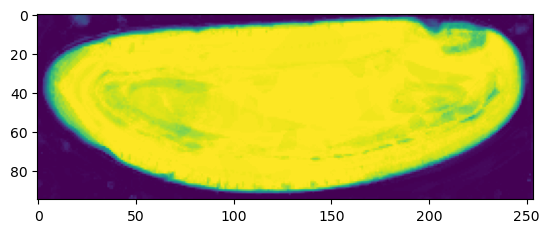

In [9]:
# look at the segmentation in a cross section

plt.imshow(segmentation[:,:,50], vmin=0, vmax=1)

## Meshing

We convert the segmentation into a triangular mesh using the marching cubes method, and save the mesh. We save all meshes in as wavefront `.obj` files (see [wikipedia](https://en.wikipedia.org/wiki/Wavefront_.obj_file)). In python, we represent missing entries (such as a vertex which doesn't have a normal by `np.nan`.

**Important convention** For sanities sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

In [10]:
# now we create a 3d mesh of using the marching cubes method

level_set = mcubes.smooth(segmentation, method="gaussian", sigma=2)
# converts segmentation into level set, with 0=surface
vertices, faces = mcubes.marching_cubes(level_set, 0)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

In [11]:
mesh = tcio.ObjMesh(vertices_in_microns, faces)
mesh.name = "Drosophila_CAAX-mCherry_mesh_marching_cubes"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

In [12]:
# improve mesh quality using meshlab
ms = pymeshlab.MeshSet()
ms.load_new_mesh(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")
ms.meshing_isotropic_explicit_remeshing()
ms.save_current_mesh(f"{metadata_dict['filename']}_mesh_remeshed.obj")

## Registration

Using the tools from notebook 4, compute an affine registration of the reference onto the data mesh.

In [14]:
mesh_data = tcio.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")
mesh_ref = tcio.ObjMesh.read_obj(f"wrapping_example/Drosophila_reference.obj")

In [15]:
trafo_centroid_intertia, _ = tcreg.align_by_centroid_and_intertia(mesh_ref.vertices, mesh_data.vertices,
                                                                  q=0.01, shear=True)

trafo_icp, _, _ = tcreg.icp(mesh_ref.vertices, mesh_data.vertices, initial=trafo_centroid_intertia,
                            threshold=1e-4, max_iterations=100, scale=True, n_samples=5000)

In [16]:
# we now save the pre-registered mesh. Note that we want to transform both our
# mesh coordinates and the corresponding normals, as well as potentially flip face orientation

mesh_registered = mesh_ref.apply_affine_to_mesh(trafo_icp)
mesh_registered.name = "Drosophila_reference_preregistered"
mesh_registered.write_obj(f"wrapping_example/Drosophila_reference_preregistered.obj")

## Procedural wrapping

We can also automatically wrap using blender's python API. Let's see how it works. 
- `trimesh.proximity` appears not feasible - way too slow, 15s for 1k vertices.
- Annoyingly, blender scripts cannot be directly run from python. It must be done from within the blender script window. The goal here would be to write a script that can be either easily run in blender, or run from the command line (also possible via python's `shutil`).
- `open3d` is another option - see [here](https://www.open3d.org/docs/latest/tutorial/geometry/distance_queries.html). However, this adds another big dependency to the project.
- `pymeshlab`'s `transfer_attributes_per_vertex`

We will use the interfacing tools from notebooks 1b, 1c which allow us to convert our `ObjMesh` into `pymeshlab` or `open3d` classes.

### `pymeshlab`

In [ ]:
# Load mesh and convert to open3d.t.geometry.TriangleMesh. Then get raycasting scene


### `open3d`

In [38]:
reload(into3d); reload(intmsl); reload(tcio)

<module 'blender_tissue_cartography.io' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/io.py'>

In [32]:
# Load mesh and convert to open3d.t.geometry.TriangleMesh. Then get raycasting scene
mesh_target = tcio.ObjMesh.read_obj("wrapping_example/Drosophila_CAAX-mCherry_mesh_remeshed.obj")
mesh_target = into3d.convert_to_open3d(mesh_target)

In [39]:
mesh_source = tcio.ObjMesh.read_obj("wrapping_example/Drosophila_reference_preregistered.obj")

In [40]:
mesh_source = into3d.convert_to_open3d(mesh_source)

In [ ]:
# can we speed up the reading & conversion processes

In [29]:
# create a raycasting scene and compute the closest point on the surface of the target mesh
scene = o3d.t.geometry.RaycastingScene()
_ = scene.add_triangles(mesh_target)
query_points = mesh_source.vertex.positions.numpy()
closest_points = scene.compute_closest_points(o3d.core.Tensor(query_points, dtype=o3d.core.Dtype.Float32))["points"]
mesh_source.vertex.positions = closest_points

In [30]:
mesh_source_wrapped = into3d.convert_from_open3d(mesh_source)

In [31]:
tcio.ObjMesh.read_obj("wrapping_example/Drosophila_reference_wrapepd_o3d.obj")

In [ ]:
# We compute the closest point on the surface
query_points = mesh_source.vertex.positions.numpy()
closest_points = scene.compute_closest_points(o3d.core.Tensor(query_points,
                                                             dtype=o3d.core.Dtype.Float32))["points"].numpy()
mesh_source.vertex.positions = o3d.core.Tensor(closest_points, dtype=o3d.core.Dtype.Float32)
# recompute the normals
mesh_source = mesh_source.to_legacy()
mesh_source = mesh_source.compute_vertex_normals()

In [303]:
%%timeit
o3d.io.write_triangle_mesh("registration_example/Drosophila_reference_wrapepd_o3d.obj", mesh_source)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
2.23 s ± 74.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [325]:
%%timeit
mesh_source.write_obj("registration_example/Drosophila_reference_wrapepd_o3d.obj")

146 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## UV projection

To see how well all of this has worked, let's use the wrapped mesh to generate UV projections. We will compare it with the automatic sphere unwrap on the original data mesh.

In [95]:
normal_offsets = np.array([-4, -2, 0, 2]) ##np.linspace(-5, 2, 8) # in microns
metadata_dict["normal_offsets"] = normal_offsets # add the info to the metadata
uv_grid_steps = 512

In [211]:
tcio.save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [96]:
projected_data_wrapped, projected_coordinates_wrapped, projected_normals_wrapped = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"registration_example/Drosophila_reference_wrapped.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

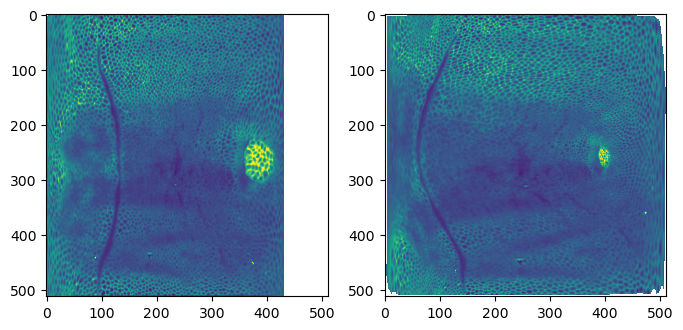

In [98]:
# show the projected data - why is there a systematic error when using the wrapped mesh??

fig, (ax1, ax2) = plt.subplots(figsize=(8,8), ncols=2)
ax1.imshow(projected_data_wrapped[0, 0], vmax=10000)
ax2.imshow(projected_data_wrapped[0, 2][::-1,::-1].T, vmax=10000)

In [56]:
# save images for visualization in blender
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures"
tcio.save_stack_for_blender(projected_data_wrapped, texture_path, normalization=(0.01, 0.99))

In [50]:
# save images as .tif stack for analysis
tcio.save_for_imageJ(f"{metadata_dict['filename']}_projected.tif", projected_data_wrapped, z_axis=1)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_3d_coordinates.tif", projected_coordinates_wrapped)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_normals.tif", projected_normals_wrapped)

Let's add a shader to check the texture looks good:

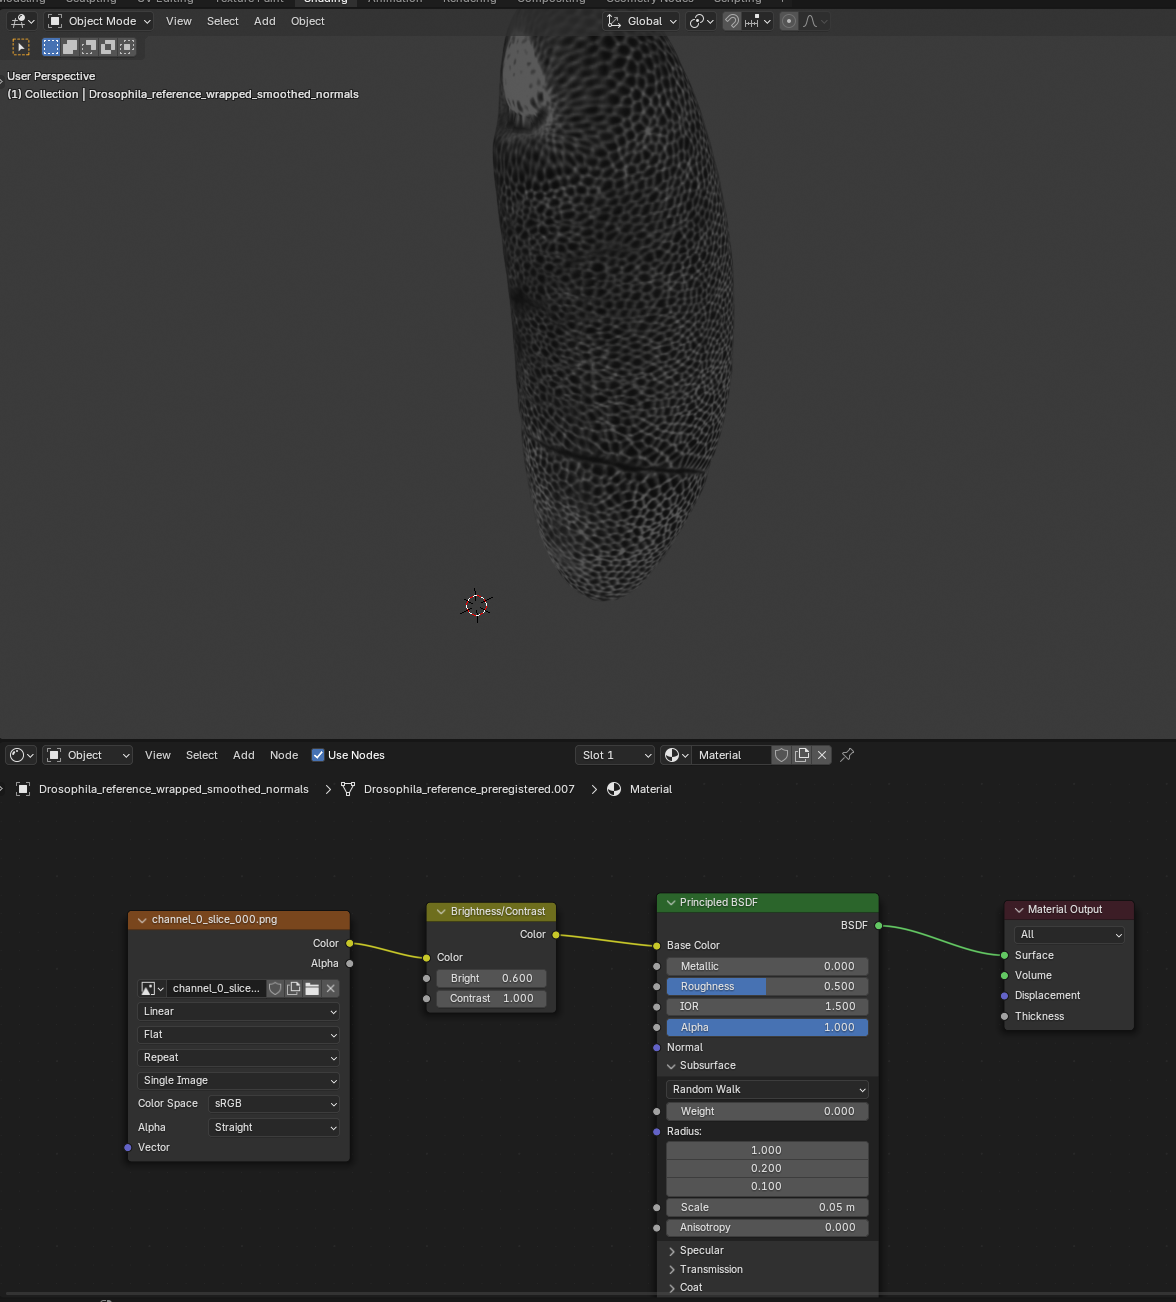
